# Import packages

In [1]:
import pandas as pd
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from arch.unitroot import ADF
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, moment, jarque_bera
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from ydata_profiling import ProfileReport

# Download data and explore

In [2]:
# Download data using the yahoo finance API

df = yf.download('^GSPC', start='2000-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Info about dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5030 entries, 2000-01-03 00:00:00-05:00 to 2019-12-30 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5030 non-null   float64
 1   High       5030 non-null   float64
 2   Low        5030 non-null   float64
 3   Close      5030 non-null   float64
 4   Adj Close  5030 non-null   float64
 5   Volume     5030 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.1 KB


In [4]:
# Checking the null values

df.isna().sum().sum()

0

In [5]:
# Filter data down to closing prices

df= df[['Adj Close']]

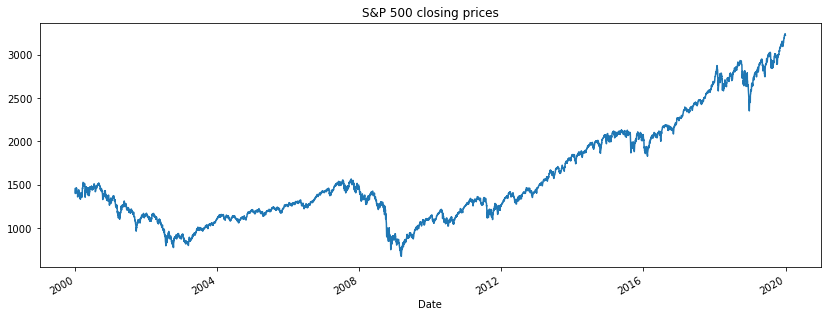

In [6]:
# Plot closing prices

fig, ax = plt.subplots(figsize=(14, 5))

df.plot(ax=ax)

ax.set_title('S&P 500 closing prices')

ax.get_legend().remove()

#plt.savefig('sp500 closing prices', dpi=300, facecolor='white',bbox_inches='tight' );

# Transform data and explore

In [7]:
# Calculate return and log return
df['Log_Return'] = np.log(df['Adj Close']).diff().mul(100)

In [8]:
# Check some values

df.head(9)

,Adj Close,Log_Return
Date,,
2000-01-03 00:00:00-05:00,1455.219971,NaN
2000-01-04 00:00:00-05:00,1399.420044,-3.909918
2000-01-05 00:00:00-05:00,1402.109985,0.192034
2000-01-06 00:00:00-05:00,1403.449951,0.095522
2000-01-07 00:00:00-05:00,1441.469971,2.672995
2000-01-10 00:00:00-05:00,1457.599976,1.112782
2000-01-11 00:00:00-05:00,1438.560059,-1.314858
2000-01-12 00:00:00-05:00,1432.250000,-0.439602
2000-01-13 00:00:00-05:00,1449.680054,1.209625


Thanks to the transformation we get NAs, need to delete that for models to better perform

In [9]:
#Drop NA values

df = df.dropna()

In [10]:
# Get descriptive statistics

df.describe()

,Adj Close,Log_Return
count,5029.000000,5029.000000
mean,1574.703865,0.015801
std,585.587315,1.189909
min,676.530029,-9.469512
25%,1151.439941,-0.471209
50%,1360.689941,0.054537
75%,1986.449951,0.566715
max,3240.020020,10.957197


In [11]:
df.kurtosis()

Adj Close    -0.071044
Log_Return    8.652257
dtype: float64

In [12]:
df.skew()

Adj Close     0.988683
Log_Return   -0.229555
dtype: float64

In [13]:
print(f' Jarque Bera test for Closing price: {jarque_bera(x=df["Adj Close"])}')
print(f' Jarque Bera test for Log Return: {jarque_bera(x=df["Log_Return"])}')

 Jarque Bera test for Closing price: Jarque_beraResult(statistic=819.9060592064609, pvalue=0.0)
 Jarque Bera test for Log Return: Jarque_beraResult(statistic=15695.267017519633, pvalue=0.0)


In [14]:
ADF(df['Adj Close'])

Test Statistic,1.582
P-value,0.998
Lags,19


In [15]:
ADF(df['Log_Return'])

Test Statistic,-17.222
P-value,0.000
Lags,17


In [16]:
df['Daily_Vol'] = (df['Log_Return'] - df['Log_Return'].mean())**2

In [17]:
df

,Adj Close,Log_Return,Daily_Vol
Date,,,
2000-01-04 00:00:00-05:00,1399.420044,-3.909918,15.411265
2000-01-05 00:00:00-05:00,1402.109985,0.192034,0.031058
2000-01-06 00:00:00-05:00,1403.449951,0.095522,0.006355
2000-01-07 00:00:00-05:00,1441.469971,2.672995,7.060681
2000-01-10 00:00:00-05:00,1457.599976,1.112782,1.203369
...,...,...,...
2019-12-23 00:00:00-05:00,3224.010010,0.086577,0.005009
2019-12-24 00:00:00-05:00,3223.379883,-0.019547,0.001249
2019-12-26 00:00:00-05:00,3239.909912,0.511506,0.245724


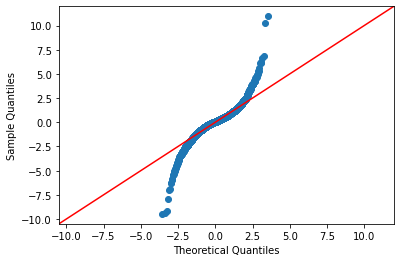

In [18]:
sm.qqplot(df['Log_Return'], line ='45')

plt.savefig('logretqqplot', dpi=300, facecolor='white',bbox_inches='tight' )

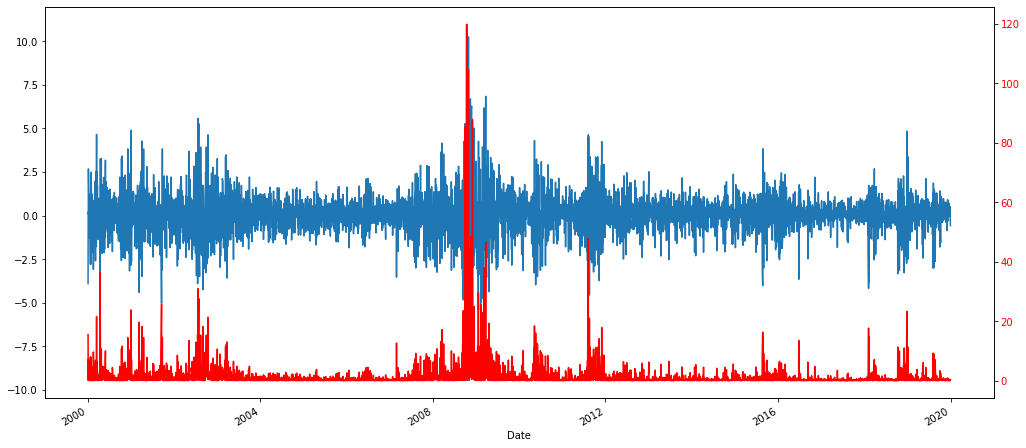

In [19]:
fig, ax1 = plt.subplots(figsize=(17, 8))

ax2 = ax1.twinx()

df.Log_Return.plot(ax=ax1)
df.Daily_Vol.plot(ax=ax2, color='red')

ax2.tick_params(axis ='y', labelcolor = 'red')

Text(0.5, 1.0, 'S&P 500 logarithmic return')

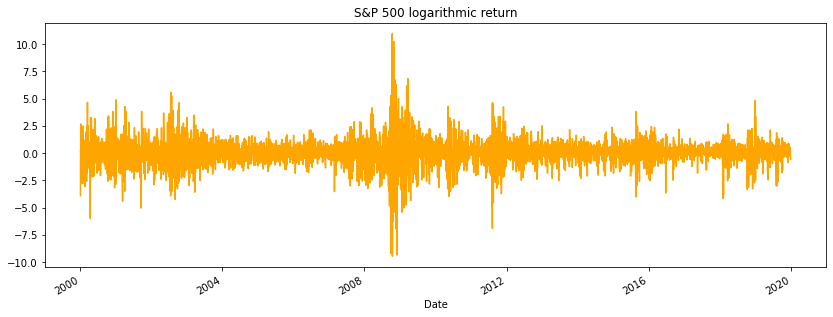

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))

df.Log_Return.plot(color='orange', ax=ax)

ax.set_title('S&P 500 logarithmic return')

#plt.savefig('sp500 logreturn', dpi=300, facecolor='white',bbox_inches='tight' );

Text(0.5, 1.0, 'S&P 500 daily volatility')

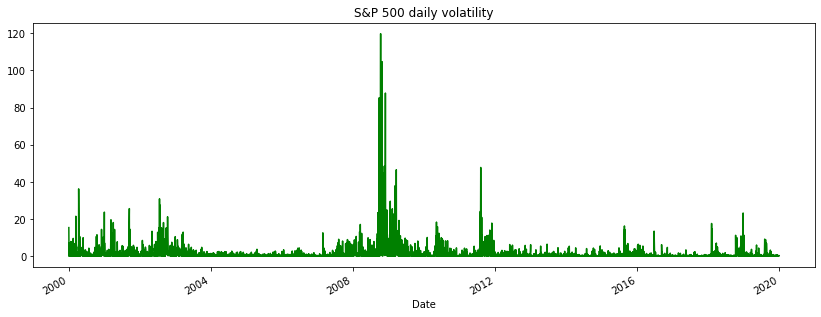

In [21]:
fig, ax = plt.subplots(figsize=(14, 5))

df.Daily_Vol.plot(color='green', ax=ax)

ax.set_title('S&P 500 daily volatility')

#plt.savefig('sp500 dailyvol', dpi=300, facecolor='white',bbox_inches='tight' );

# Specify models

In [22]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [23]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    #stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    #axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    #s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    #axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

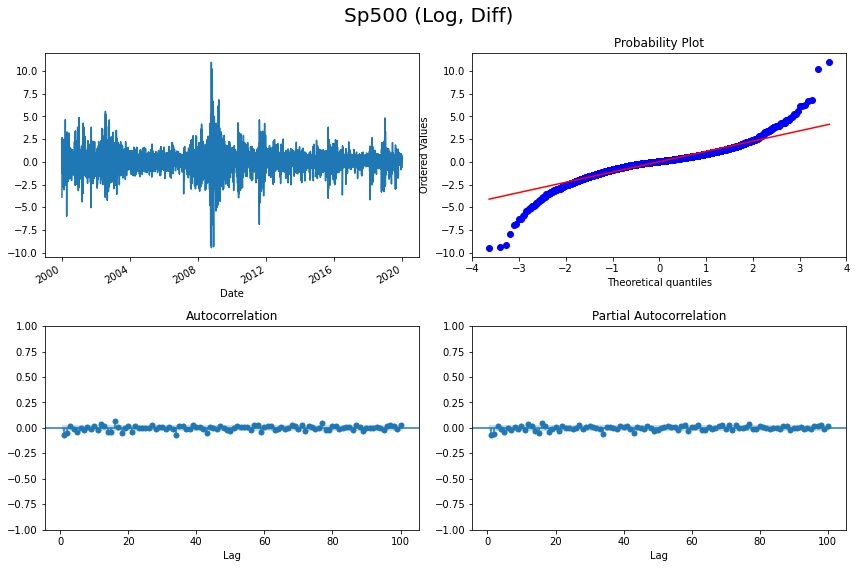

In [24]:
plot_correlogram(df['Log_Return'], lags=100, title='Sp500 (Log, Diff)')

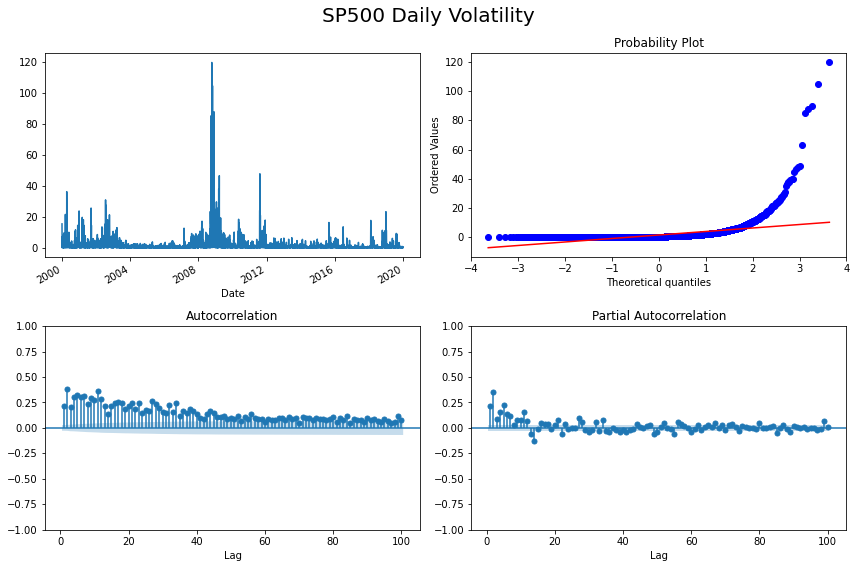

In [25]:
plot_correlogram(df['Log_Return'].sub(df['Log_Return'].mean()).pow(2), lags=100, title='SP500 Daily Volatility')

# Garch models

In [26]:
garch11 = arch_model(df['Log_Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

garch11res = garch11.fit(update_freq = 4, disp='off')

print(garch11res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6818.91
Distribution:                  Normal   AIC:                           13645.8
Method:            Maximum Likelihood   BIC:                           13671.9
                                        No. Observations:                 5029
Date:                Fri, Mar 31 2023   Df Residuals:                     5028
Time:                        15:26:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0584  1.116e-02      5.235  1.648e-07 [3.

In [27]:
garchskewt = arch_model(df['Log_Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

garchskewtres = garchskewt.fit(update_freq = 4, disp='off')

print(garchskewtres.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                        Log_Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -6693.61
Distribution:      Standardized Skew Student's t   AIC:                           13399.2
Method:                       Maximum Likelihood   BIC:                           13438.4
                                                   No. Observations:                 5029
Date:                           Fri, Mar 31 2023   Df Residuals:                     5028
Time:                                   15:26:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [28]:
garchstudent = arch_model(df['Log_Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'studentst')

garchstudentres = garchstudent.fit(update_freq = 4, disp='off')

print(garchstudentres.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6707.87
Distribution:      Standardized Student's t   AIC:                           13425.7
Method:                  Maximum Likelihood   BIC:                           13458.4
                                              No. Observations:                 5029
Date:                      Fri, Mar 31 2023   Df Residuals:                     5028
Time:                              15:26:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

# EGARCH models

In [29]:

egarch = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 'normal')

egarchres = egarch.fit(update_freq = 4,disp = 'off')

print(egarchres.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -6691.48
Distribution:                  Normal   AIC:                           13393.0
Method:            Maximum Likelihood   BIC:                           13425.6
                                        No. Observations:                 5029
Date:                Fri, Mar 31 2023   Df Residuals:                     5028
Time:                        15:26:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0226  1.065e-02      2.122  3.387e-02 [1.

In [30]:
egarchstud = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 'studentst')

egarchstudres = egarchstud.fit(disp = 'off')

print(egarchstudres.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -6600.46
Distribution:      Standardized Student's t   AIC:                           13212.9
Method:                  Maximum Likelihood   BIC:                           13252.1
                                              No. Observations:                 5029
Date:                      Fri, Mar 31 2023   Df Residuals:                     5028
Time:                              15:26:48   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [31]:
egarchskew = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 'skewt')

egarchskewres = egarchskew.fit(disp = 'off')

print(egarchskewres.summary())

                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                        Log_Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -6574.16
Distribution:      Standardized Skew Student's t   AIC:                           13162.3
Method:                       Maximum Likelihood   BIC:                           13208.0
                                                   No. Observations:                 5029
Date:                           Fri, Mar 31 2023   Df Residuals:                     5028
Time:                                   15:26:48   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

# GJR models

In [32]:

gjr = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 'normal')

gjrres = gjr.fit(disp = 'off')

print(gjrres.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6704.22
Distribution:                  Normal   AIC:                           13418.4
Method:            Maximum Likelihood   BIC:                           13451.1
                                        No. Observations:                 5029
Date:                Fri, Mar 31 2023   Df Residuals:                     5028
Time:                        15:26:48   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0189  1.116e-02      1.692  9.061e-02 

In [33]:
gjrstud = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 'studentst')

gjrstudres = gjrstud.fit(disp = 'off')

print(gjrstudres.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6618.29
Distribution:      Standardized Student's t   AIC:                           13248.6
Method:                  Maximum Likelihood   BIC:                           13287.7
                                              No. Observations:                 5029
Date:                      Fri, Mar 31 2023   Df Residuals:                     5028
Time:                              15:26:48   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [34]:
gjrskew = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 'skewt')

gjrskewres = gjrskew.fit(disp = 'off')

print(gjrskewres.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                        Log_Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -6592.71
Distribution:      Standardized Skew Student's t   AIC:                           13199.4
Method:                       Maximum Likelihood   BIC:                           13245.1
                                                   No. Observations:                 5029
Date:                           Fri, Mar 31 2023   Df Residuals:                     5028
Time:                                   15:26:49   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

# Aparch models

In [35]:
aparch = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'APARCH', dist = 'normal')

aparchres = aparch.fit(disp = 'off')

print(aparchres.summary())

                     Constant Mean - APARCH Model Results                     
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     APARCH   Log-Likelihood:               -6671.43
Distribution:                  Normal   AIC:                           13354.9
Method:            Maximum Likelihood   BIC:                           13394.0
                                        No. Observations:                 5029
Date:                Fri, Mar 31 2023   Df Residuals:                     5028
Time:                        15:26:49   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0164  1.258e-02      1.308      0.191 

In [36]:
aparchskew = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'APARCH', dist = 'skewt')

aparchskewres = aparchskew.fit(disp = 'off')

print(aparchskewres.summary())

                           Constant Mean - APARCH Model Results                          
Dep. Variable:                        Log_Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                APARCH   Log-Likelihood:               -6560.72
Distribution:      Standardized Skew Student's t   AIC:                           13137.4
Method:                       Maximum Likelihood   BIC:                           13189.6
                                                   No. Observations:                 5029
Date:                           Fri, Mar 31 2023   Df Residuals:                     5028
Time:                                   15:26:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

In [37]:
aparchstud = arch_model(df['Log_Return'], p = 1, q = 1, o = 1, vol = 'APARCH', dist = 'studentst')

aparchstudres = aparchstud.fit(disp = 'off')

print(aparchstudres.summary())

                        Constant Mean - APARCH Model Results                        
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           APARCH   Log-Likelihood:               -6589.20
Distribution:      Standardized Student's t   AIC:                           13192.4
Method:                  Maximum Likelihood   BIC:                           13238.1
                                              No. Observations:                 5029
Date:                      Fri, Mar 31 2023   Df Residuals:                     5028
Time:                              15:26:51   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

# Forecast

In [38]:
df.tail(60).head(1)

,Adj Close,Log_Return,Daily_Vol
Date,,,
2019-10-04 00:00:00-04:00,2952.01001,1.411679,1.948474


In [39]:
df.tail(30).head(1)

,Adj Close,Log_Return,Daily_Vol
Date,,,
2019-11-15 00:00:00-05:00,3120.459961,0.766603,0.563704


In [40]:
index = df.index
start_loc = 0
end_loc = np.where(index >= '2019-10-04')[0].min()
forecasts = {}

for i in range(60):
        sys.stdout.write('-')
        sys.stdout.flush()
        res = garchskewt.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
        temp = res.forecast(horizon=1).variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast
print(' Done!')
garchskewt60_res = pd.DataFrame(forecasts).T

------------------------------------------------------------ Done!


In [45]:
index = df.index
start_loc = 0
end_loc = np.where(index >= '2019-11-15')[0].min()
forecasts = {}

for i in range(30):
        sys.stdout.write('-')
        sys.stdout.flush()
        res = garchskewt.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
        temp = res.forecast(horizon=1).variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast
print(' Done!')
garchskewt30_res = pd.DataFrame(forecasts).T

------------------------------ Done!


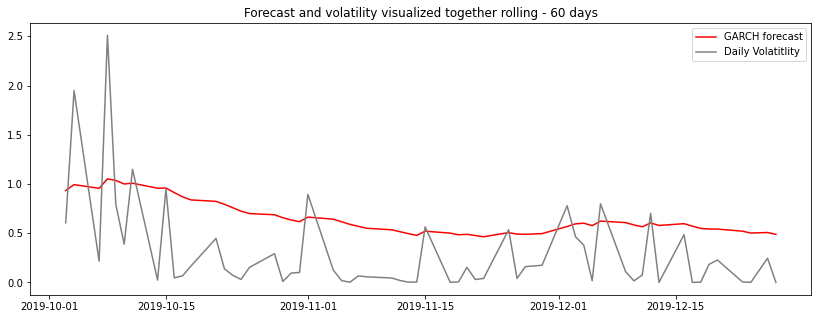

In [52]:
# Plot results
fig, ax = plt.subplots(figsize=(14, 5))


# Plot volatility forecast with an expanding window
plt.plot(np.sqrt(garchskewt60_res), color = 'red', label='GARCH forecast')

plt.plot(df.Daily_Vol.loc[garchskewt60_res.index], color = 'grey', label='Daily Volatitlity')

plt.legend(loc="upper right")
plt.title('Forecast and volatility visualized together rolling - 60 days')

plt.savefig('forecast and vol 60', dpi=300, facecolor='white',bbox_inches='tight' )

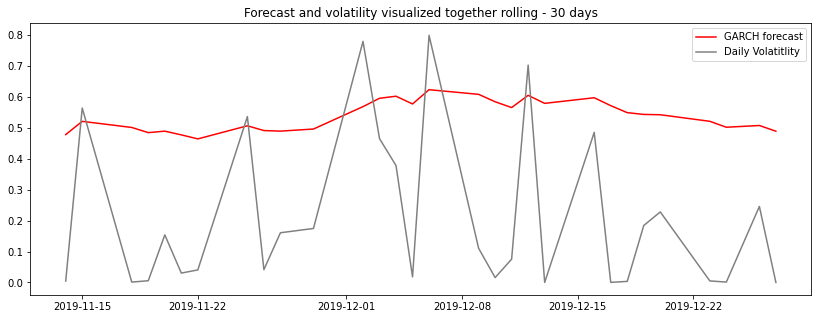

In [53]:
# Plot results
fig, ax = plt.subplots(figsize=(14, 5))


# Plot volatility forecast with an expanding window
plt.plot(np.sqrt(garchskewt30_res), color = 'red', label='GARCH forecast')

plt.plot(df.Daily_Vol.loc[garchskewt30_res.index], color = 'grey', label='Daily Volatitlity')

plt.legend(loc="upper right")
plt.title('Forecast and volatility visualized together rolling - 30 days')
plt.savefig('forecast and vol 30', dpi=300, facecolor='white',bbox_inches='tight' )

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

In [44]:
evaluate(df['Daily_Vol'].loc[garchskewt60_res.index], garchskewt60_res**2)

Mean Absolute Error (MAE): 0.24
Mean Squared Error (MSE): 0.131


(0.24013581680696755, 0.13133667947502992)

In [49]:
evaluate(df['Daily_Vol'].loc[garchskewt30_res.index], garchskewt30_res**2)

Mean Absolute Error (MAE): 0.182
Mean Squared Error (MSE): 0.071


(0.18233099290491436, 0.0710541281646459)